In [8]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import OneSidedSelection
from imblearn.under_sampling import NearMiss
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from imblearn.metrics import sensitivity_specificity_support
from sklearn.metrics import precision_recall_fscore_support
from itertools import cycle
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, average_precision_score
import time

In [18]:
#independent dataset
indep = pd.read_table("/DAS_Storage1/aschoi/data/Drug_Repositioning/8_new_training/2_2_indep_asso_descriptor.tsv")
indep_x = indep.values[:, 3:].astype(float)
indep_y = indep.values[:,2].astype(int)

In [9]:
# removed independent dataset
indep = pd.read_table("/DAS_Storage1/aschoi/data/Drug_Repositioning/8_new_training/2_2_2_removed_indep_descriptor.tsv")
indep_x = indep.values[:, 3:].astype(float)
indep_y = indep.values[:,2].astype(int)

In [3]:
# removed descriptor training
df = pd.read_table("/DAS_Storage1/aschoi/data/Drug_Repositioning/8_new_training/2_1_2_removed_descriptor.tsv")
x_whole_data = df[df.columns.values[3:].tolist()].values
y_whole_data = df["association"].values

In [10]:
#2017.3.15. TN_whole removed descriptor
df = pd.read_table("/DAS_Storage1/aschoi/data/Drug_Repositioning/8_new_training/7_2_1_tn_whole_descriptor_removed.tsv")
x_whole_data = df[df.columns.values[3:].tolist()].values
y_whole_data = df["association"].values

In [19]:
#2017.3.14. TN_whole 기존 descriptor
df = pd.read_table("/DAS_Storage1/aschoi/data/Drug_Repositioning/8_new_training/6_2_1_tn_whole_descriptor.tsv")
x_whole_data = df[df.columns.values[3:].tolist()].values
y_whole_data = df["association"].values

In [3]:
#기존 데이터
#association_data = pd.read_table("/DAS_Storage1/aschoi/data/Drug_Repositioning/7_new_association/9_gold_learning_association.tsv")
#descriptor_data = pd.read_table("/DAS_Storage1/aschoi/data/Drug_Repositioning/8_new_training/2_1_descriptor_combined.tsv", header=None) # 이거 현재 바뀜.
df = pd.read_table("/DAS_Storage1/aschoi/data/Drug_Repositioning/8_new_training/2_1_descriptor_combined.tsv")
x_whole_data = df[df.columns.values[3:].tolist()].values
y_whole_data = df["association"].values

In [4]:
# new descriptor - TN 구분한 data(2017.1.16.) 수정됨. 2017.1.23.
df = pd.read_table("/DAS_Storage1/aschoi/data/Drug_Repositioning/8_new_training/4_gold_descriptor_revised_1%.tsv")
x_whole_data_1 = df[df.columns.values[3:].tolist()].values
y_whole_data_1 = df["association"].values

# new descriptor - TN 구분한 data(2017.1.16.) 수정됨. 2017.1.23. 추가됨 2017.2.1.
df = pd.read_table("/DAS_Storage1/aschoi/data/Drug_Repositioning/8_new_training/4_gold_descriptor_revised_0.5%.tsv")
x_whole_data_0_5 = df[df.columns.values[3:].tolist()].values
y_whole_data_0_5 = df["association"].values

df = pd.read_table("/DAS_Storage1/aschoi/data/Drug_Repositioning/8_new_training/4_gold_descriptor_revised_0.1%.tsv")
x_whole_data_0_1 = df[df.columns.values[3:].tolist()].values
y_whole_data_0_1 = df["association"].values

In [4]:
from sklearn.metrics import roc_curve, auc, average_precision_score

def Random_Forest_independent(x_whole_data, y_whole_data, indep_x, indep_y, user_estimators):

    #classifier = LogisticRegression(penalty='l1', C=user_c, n_jobs = -1)
    classifier = RandomForestClassifier(n_estimators=user_estimators, n_jobs=-1, class_weight='balanced')
    classifier.fit(x_whole_data, y_whole_data)
    indep_y_predicted_proba = classifier.predict_proba(indep_x)
    indep_y_predicted_label = classifier.predict(indep_x)

    indep_accuracy = classifier.score(indep_x, indep_y)
    indep_fpr, indep_tpr, indep_thresholds = roc_curve(indep_y, indep_y_predicted_proba[:, 1], pos_label = 1)
    indep_auc = auc(indep_fpr, indep_tpr)
    indep_sn, indep_sp, _ = sensitivity_specificity_support(indep_y, indep_y_predicted_label)
    indep_precision, indep_recall, _, _ = precision_recall_fscore_support(y_validation_set, y_predicted_label, average = 'binary')
    indep_aupr = average_precision_score(indep_y, indep_y_predicted_proba[:, 1])
    indep_confusion_matirx = confusion_matrix(indep_y, indep_y_predicted_label)
    indep_precision_vec, indep_recall_vec, _ = precision_recall_curve(indep_y, indep_y_predicted_proba[:, 1])

    return [indep_accuracy, indep_auc, indep_aupr, indep_confusion_matirx, inep_sn, indep_sp, indep_precision, indep_recall]
  

In [96]:
def Random_Forest_independent_10_fold(x_whole_data, y_whole_data, indep_x, indep_y, user_estimators, undersampler):
    #rus = RandomUnderSampler()
    whole_accuracy = list()
    whole_auc = list()
    whole_aupr = list()
    whole_confusion_mat = list()
    whole_precision = list()
    whole_recall = list()
    whole_sn = list()
    whole_sp = list()
    for i in range(0, 10):
        x_resampled, y_resampled = undersampler.fit_sample(indep_x, indep_y)
        indep_result = Random_Forest_independent(x_whole_data, y_whole_data, x_resampled, y_resampled, user_estimators)
        whole_accuracy.append(indep_result[0])
        whole_auc.append(indep_result[1])
        whole_aupr.append(indep_result[2])
        whole_confusion_mat.append(indep_result[3])
        #whole_predicted_proba.append([y_resampled, indep_result[4]])
        whole_sn.append(indep_result[4])
        whole_sp.append(indep_result[5])
        whole_precision.append(indep_result[6])
        whole_recall.append(indep_result[7])
        print('Original dataset shape {}'.format(Counter(indep_y)))
    print('\nResampled dataset shape {}'.format(Counter(y_resampled)))
    avg_acc = sum(whole_accuracy)/len(whole_accuracy)
    avg_auc = sum(whole_auc)/len(whole_auc)
    avg_aupr = sum(whole_aupr)/len(whole_aupr)
    confusion_matrix = sum(whole_confusion_mat)
    avg_sn = sum(whole_sn) / len(whole_sn)
    avg_sp = sum(whole_sp) / len(whole_sp)
    avg_precision = sum(whole_precision) / len(whole_precision)
    avg_recall = sum(whole_recall) / len(whole_recall)
    return [avg_acc, avg_auc, avg_aupr, confusion_matrix, avg_sn, avg_sp, avg_precision, avg_recall]

In [5]:
def write_output(filedescritor, results):
    f.write("Accuracy : {}\r\n".format(results[0]))
    f.write("AUC : {}\r\n".format(results[1]))
    f.write("  Sensitivity avg : {}\r\n".format(results[4]))
    f.write("  Specificity avg : {}\r\n".format(results[5]))
    f.write("AUPR : {}\r\n".format(results[2]))
    f.write("  Precision avg : {}\r\n".format(results[6]))
    f.write("  Recall avg : {}\r\n".format(results[7]))
    f.write("confusion amtrix : {}\r\n".format(results[3]))

In [6]:
def write_proba_output(file_name, results):
    with open("/home/share/aschoi/nas/users/asolchoi/data/Drug_Repositioning/8_new_training/{}".format(file_name), 'w') as fd:
        indep_y_predicted_proba = results[4].tolist()
        for item in indep_y_predicted_proba:
            fd.write("{}\t{}\n".format(item[0], item[1]))

In [4]:
plt.clf()
f, axes = plt.subplots(1, 2, figsize=(15, 5))
def draw_AUC_curve(f, axes, fpr, tpr, recall_vec, precision_vec, i):
    
    # setup plot details
    %matplotlib inline

    lw = 2
    colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange', 'red', 'violet', 'fuchsia', 'sienna'])
    
    # plot AUC
    axes[0].plot(fpr, tpr, lw=lw, color=color, label=lab1)
    lab1 = 'Fold %d AUC=%.4f' % (i+1, current_auc)
    
    # plot AUPR
    axes[1].plot(recall_vec, precision_vec, lw=lw, color=color, label=lab2)
    lab2 = 'Fold %d AUPR=%.4f' % (i+1, current_aupr)
    
    axes[0].set_xlabel('FPR')
    axes[0].set_ylabel('TPR')
    axes[0].set_ylim([0.0, 1.05])
    axes[0].set_xlim([0.0, 1.0])
    axes[0].set_title('Average AUC={0:0.2f}'.format(avg_auc))
    axes[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
    axes[1].set_xlabel('Recall')
    axes[1].set_ylabel('Precision')
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_title('Agerage AUPR={0:0.2f}'.format(avg_aupr))
    axes[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
    f.subplots_adjust(wspace=0.8)
    
    
    
    #f, axes = plt.subplots(1, 2, figsize=(15, 5))
    #plt.plot(recall, precision, lw=lw, color='navy', label='Precision-Recall Curve')
    #plt.xlabel('Recall')
    #plt.ylabel('Precision')
    #plt.ylim([0.0, 1.05])
    #plt.xlim([0.0, 1.0])
    #plt.title('Precision-Recall example: AUC={0:0.2f}'.format(average_precision))
    #plt.legend(loc="lower left")
    #plt.show()    

In [5]:
# undersampler
rus = RandomUnderSampler()
oss = OneSidedSelection()
nm = NearMiss()

Wed 21:14:00
Wed 21:14:03


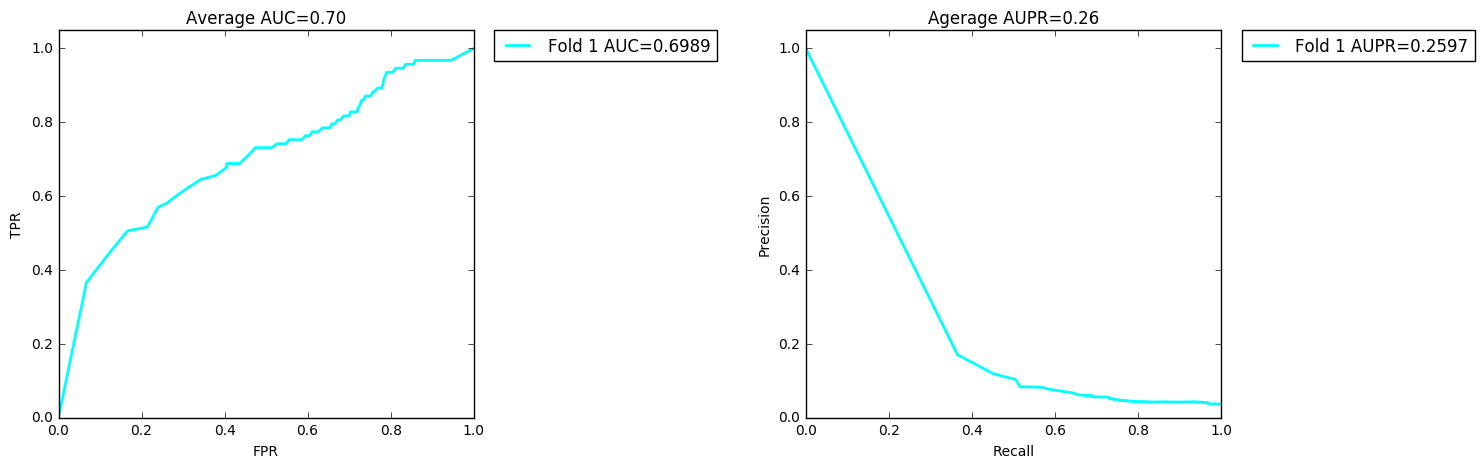

In [17]:
# removed dataset, independent, 2017.3.15. 작성
print time.strftime('%a %H:%M:%S')
with open("/home/share/aschoi/nas/users/asolchoi/data/Drug_Repositioning/8_new_training/Performance/2_9_RF_removed_TN_whole_indep2.txt", 'w') as f :
    user_estimators = 120
    f.write("<independent>\r\n")
    
    classifier = RandomForestClassifier(n_estimators=user_estimators, n_jobs=-1, class_weight='balanced')
    classifier.fit(x_whole_data, y_whole_data)
    indep_y_predicted_proba = classifier.predict_proba(indep_x)
    indep_y_predicted_label = classifier.predict(indep_x)

    indep_accuracy = classifier.score(indep_x, indep_y)
    indep_fpr, indep_tpr, indep_thresholds = roc_curve(indep_y, indep_y_predicted_proba[:, 1], pos_label = 1)
    indep_auc = auc(indep_fpr, indep_tpr)
    indep_sn, indep_sp, _ = sensitivity_specificity_support(indep_y, indep_y_predicted_label)
    indep_precision, indep_recall, _, _ = precision_recall_fscore_support(indep_y, indep_y_predicted_label, average = 'binary')
    indep_aupr = average_precision_score(indep_y, indep_y_predicted_proba[:, 1])
    indep_confusion_matirx = confusion_matrix(indep_y, indep_y_predicted_label)
    indep_precision_vec, indep_recall_vec, _ = precision_recall_curve(indep_y, indep_y_predicted_proba[:, 1])
    
    f.write("Accuracy : {}\r\n".format(indep_accuracy))
    f.write("AUC : {}\r\n".format(indep_auc))
    f.write("  Sensitivity avg : {}\r\n".format(indep_sn))
    f.write("  Specificity avg : {}\r\n".format(indep_sp))
    f.write("AUPR : {}\r\n".format(indep_aupr))
    f.write("  Precision avg : {}\r\n".format(indep_precision))
    f.write("  Recall avg : {}\r\n".format(indep_recall))
    f.write("confusion amtrix : {}\r\n".format(indep_confusion_matirx))

    %matplotlib inline
    plt.clf()
    ff, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # setup plot details
    i=0
    lw = 2
    colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange', 'red', 'violet', 'fuchsia', 'sienna'])
    
    # plot AUC
    lab1 = 'Fold %d AUC=%.4f' % (i+1, indep_auc)
    axes[0].plot(indep_fpr, indep_tpr, lw=lw, color='cyan', label=lab1)
    
    
    # plot AUPR
    lab2 = 'Fold %d AUPR=%.4f' % (i+1, indep_aupr)
    axes[1].plot(indep_recall_vec, indep_precision_vec, lw=lw, color='cyan', label=lab2)
    
    
    axes[0].set_xlabel('FPR')
    axes[0].set_ylabel('TPR')
    axes[0].set_ylim([0.0, 1.05])
    axes[0].set_xlim([0.0, 1.0])
    axes[0].set_title('Average AUC={0:0.2f}'.format(indep_auc))
    axes[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
    axes[1].set_xlabel('Recall')
    axes[1].set_ylabel('Precision')
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_title('Agerage AUPR={0:0.2f}'.format(indep_aupr))
    axes[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
    ff.subplots_adjust(wspace=0.8)

print time.strftime('%a %H:%M:%S')

Wed 21:14:50
Wed 21:15:01


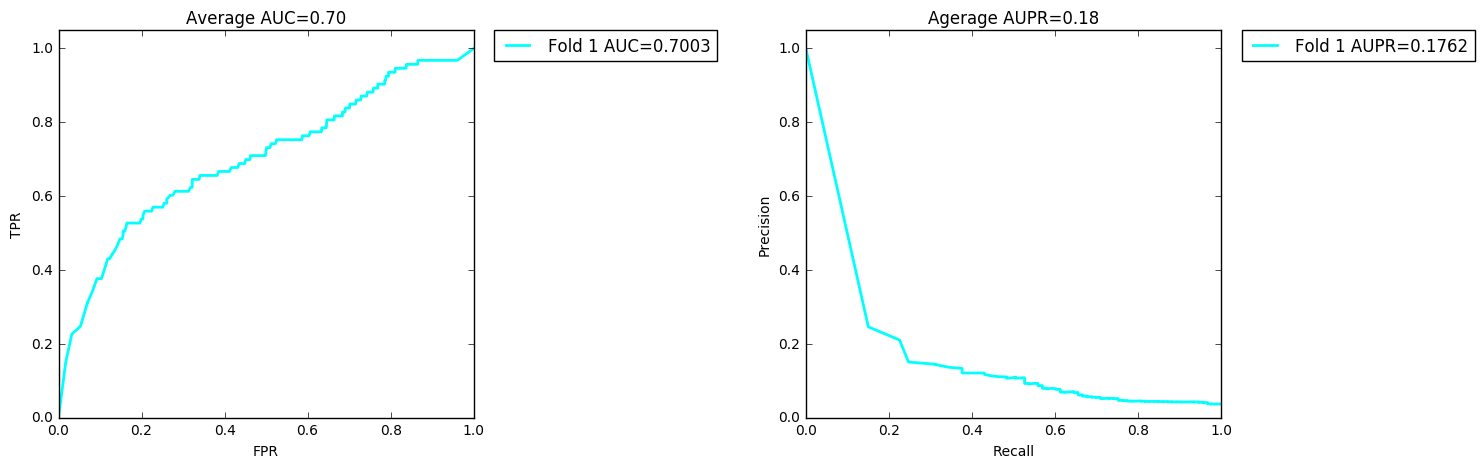

In [20]:
# original dataset, independent, 2017.3.15. 작성 다시
print time.strftime('%a %H:%M:%S')
with open("/home/share/aschoi/nas/users/asolchoi/data/Drug_Repositioning/8_new_training/Performance/2_8_RF_original_TN_whole_indep.txt", 'w') as f :
    user_estimators = 800
    f.write("<independent>\r\n")
    
    classifier = RandomForestClassifier(n_estimators=user_estimators, n_jobs=-1, class_weight='balanced')
    classifier.fit(x_whole_data, y_whole_data)
    indep_y_predicted_proba = classifier.predict_proba(indep_x)
    indep_y_predicted_label = classifier.predict(indep_x)

    indep_accuracy = classifier.score(indep_x, indep_y)
    indep_fpr, indep_tpr, indep_thresholds = roc_curve(indep_y, indep_y_predicted_proba[:, 1], pos_label = 1)
    indep_auc = auc(indep_fpr, indep_tpr)
    indep_sn, indep_sp, _ = sensitivity_specificity_support(indep_y, indep_y_predicted_label)
    indep_precision, indep_recall, _, _ = precision_recall_fscore_support(indep_y, indep_y_predicted_label, average = 'binary')
    indep_aupr = average_precision_score(indep_y, indep_y_predicted_proba[:, 1])
    indep_confusion_matirx = confusion_matrix(indep_y, indep_y_predicted_label)
    indep_precision_vec, indep_recall_vec, _ = precision_recall_curve(indep_y, indep_y_predicted_proba[:, 1])
    
    f.write("Accuracy : {}\r\n".format(indep_accuracy))
    f.write("AUC : {}\r\n".format(indep_auc))
    f.write("  Sensitivity avg : {}\r\n".format(indep_sn))
    f.write("  Specificity avg : {}\r\n".format(indep_sp))
    f.write("AUPR : {}\r\n".format(indep_aupr))
    f.write("  Precision avg : {}\r\n".format(indep_precision))
    f.write("  Recall avg : {}\r\n".format(indep_recall))
    f.write("confusion amtrix : {}\r\n".format(indep_confusion_matirx))

    %matplotlib inline
    plt.clf()
    ff, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # setup plot details
    i=0
    lw = 2
    colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange', 'red', 'violet', 'fuchsia', 'sienna'])
    
    # plot AUC
    lab1 = 'Fold %d AUC=%.4f' % (i+1, indep_auc)
    axes[0].plot(indep_fpr, indep_tpr, lw=lw, color='cyan', label=lab1)
    
    
    # plot AUPR
    lab2 = 'Fold %d AUPR=%.4f' % (i+1, indep_aupr)
    axes[1].plot(indep_recall_vec, indep_precision_vec, lw=lw, color='cyan', label=lab2)
    
    
    axes[0].set_xlabel('FPR')
    axes[0].set_ylabel('TPR')
    axes[0].set_ylim([0.0, 1.05])
    axes[0].set_xlim([0.0, 1.0])
    axes[0].set_title('Average AUC={0:0.2f}'.format(indep_auc))
    axes[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
    axes[1].set_xlabel('Recall')
    axes[1].set_ylabel('Precision')
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_title('Agerage AUPR={0:0.2f}'.format(indep_aupr))
    axes[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
    ff.subplots_adjust(wspace=0.8)

print time.strftime('%a %H:%M:%S')

Fri 11:26:12
Fri 11:27:28


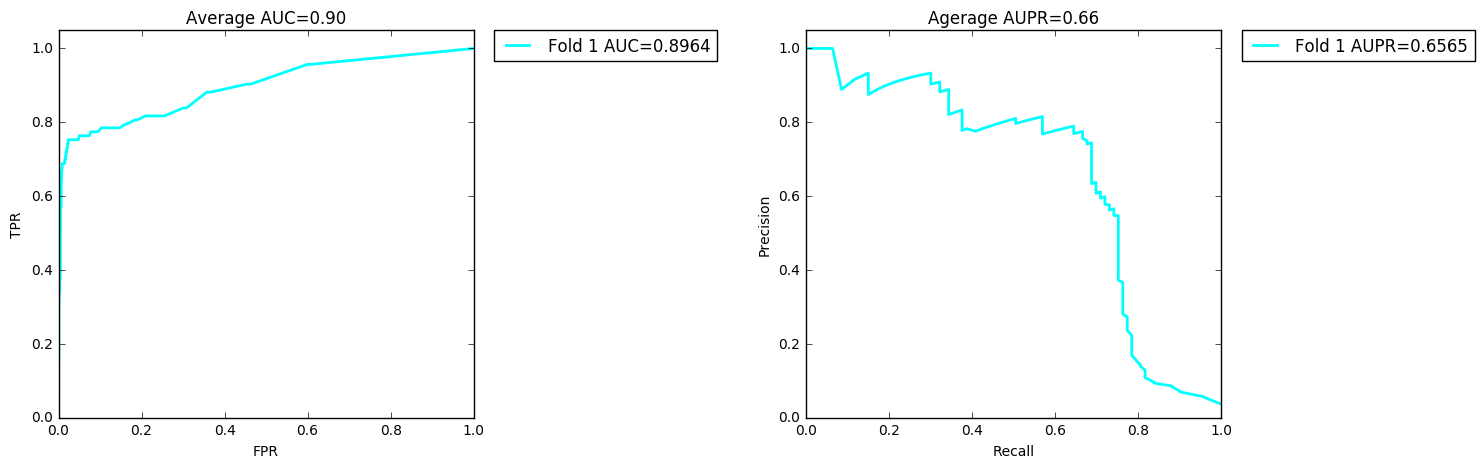

In [4]:
# revmoed dataset, independent, 2017.3.10. 작성
print time.strftime('%a %H:%M:%S')
with open("/home/share/aschoi/nas/users/asolchoi/data/Drug_Repositioning/8_new_training/Performance/2_7_RF_removed_indep_2.txt", 'w') as f :
    user_estimators = 1200
    f.write("<independent>\r\n")
    
    classifier = RandomForestClassifier(n_estimators=user_estimators, n_jobs=-1, class_weight='balanced')
    classifier.fit(x_whole_data, y_whole_data)
    indep_y_predicted_proba = classifier.predict_proba(indep_x)
    indep_y_predicted_label = classifier.predict(indep_x)

    indep_accuracy = classifier.score(indep_x, indep_y)
    indep_fpr, indep_tpr, indep_thresholds = roc_curve(indep_y, indep_y_predicted_proba[:, 1], pos_label = 1)
    indep_auc = auc(indep_fpr, indep_tpr)
    indep_sn, indep_sp, _ = sensitivity_specificity_support(indep_y, indep_y_predicted_label)
    indep_precision, indep_recall, _, _ = precision_recall_fscore_support(indep_y, indep_y_predicted_label, average = 'binary')
    indep_aupr = average_precision_score(indep_y, indep_y_predicted_proba[:, 1])
    indep_confusion_matirx = confusion_matrix(indep_y, indep_y_predicted_label)
    indep_precision_vec, indep_recall_vec, _ = precision_recall_curve(indep_y, indep_y_predicted_proba[:, 1])
    
    f.write("Accuracy : {}\r\n".format(indep_accuracy))
    f.write("AUC : {}\r\n".format(indep_auc))
    f.write("  Sensitivity avg : {}\r\n".format(indep_sn))
    f.write("  Specificity avg : {}\r\n".format(indep_sp))
    f.write("AUPR : {}\r\n".format(indep_aupr))
    f.write("  Precision avg : {}\r\n".format(indep_precision))
    f.write("  Recall avg : {}\r\n".format(indep_recall))
    f.write("confusion amtrix : {}\r\n".format(indep_confusion_matirx))

    %matplotlib inline
    plt.clf()
    ff, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # setup plot details
    i=0
    lw = 2
    colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange', 'red', 'violet', 'fuchsia', 'sienna'])
    
    # plot AUC
    lab1 = 'Fold %d AUC=%.4f' % (i+1, indep_auc)
    axes[0].plot(indep_fpr, indep_tpr, lw=lw, color='cyan', label=lab1)
    
    
    # plot AUPR
    lab2 = 'Fold %d AUPR=%.4f' % (i+1, indep_aupr)
    axes[1].plot(indep_recall_vec, indep_precision_vec, lw=lw, color='cyan', label=lab2)
    
    
    axes[0].set_xlabel('FPR')
    axes[0].set_ylabel('TPR')
    axes[0].set_ylim([0.0, 1.05])
    axes[0].set_xlim([0.0, 1.0])
    axes[0].set_title('Average AUC={0:0.2f}'.format(indep_auc))
    axes[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
    axes[1].set_xlabel('Recall')
    axes[1].set_ylabel('Precision')
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_title('Agerage AUPR={0:0.2f}'.format(indep_aupr))
    axes[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
    ff.subplots_adjust(wspace=0.8)

print time.strftime('%a %H:%M:%S')

Fri 02:35:46
Fri 02:38:16


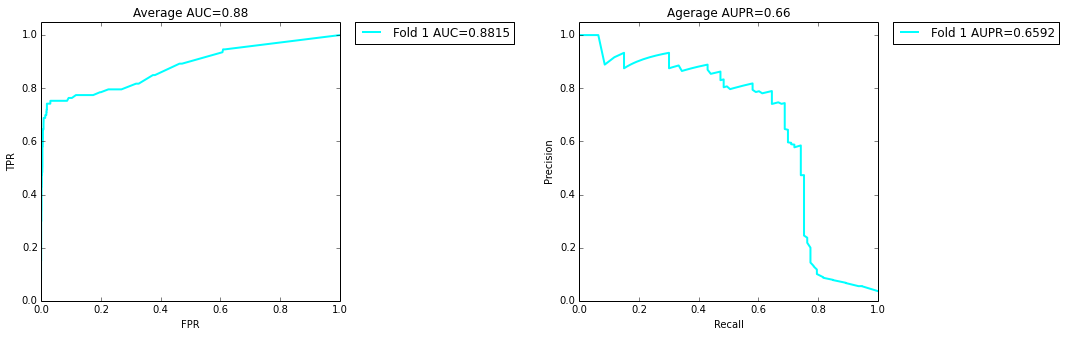

In [18]:
# 기존 dataset, independent, 2017.2.14. 작성 # 2017.2.24 수정.
print time.strftime('%a %H:%M:%S')
with open("/home/share/aschoi/nas/users/asolchoi/data/Drug_Repositioning/8_new_training/RF_original_ver2.txt", 'w') as f :
    user_estimators = 1200
    f.write("<independent>\r\n")
    
    classifier = RandomForestClassifier(n_estimators=user_estimators, n_jobs=-1, class_weight='balanced')
    classifier.fit(x_whole_data, y_whole_data)
    indep_y_predicted_proba = classifier.predict_proba(indep_x)
    indep_y_predicted_label = classifier.predict(indep_x)

    indep_accuracy = classifier.score(indep_x, indep_y)
    indep_fpr, indep_tpr, indep_thresholds = roc_curve(indep_y, indep_y_predicted_proba[:, 1], pos_label = 1)
    indep_auc = auc(indep_fpr, indep_tpr)
    indep_sn, indep_sp, _ = sensitivity_specificity_support(indep_y, indep_y_predicted_label)
    indep_precision, indep_recall, _, _ = precision_recall_fscore_support(indep_y, indep_y_predicted_label, average = 'binary')
    indep_aupr = average_precision_score(indep_y, indep_y_predicted_proba[:, 1])
    indep_confusion_matirx = confusion_matrix(indep_y, indep_y_predicted_label)
    indep_precision_vec, indep_recall_vec, _ = precision_recall_curve(indep_y, indep_y_predicted_proba[:, 1])
    
    f.write("Accuracy : {}\r\n".format(indep_accuracy))
    f.write("AUC : {}\r\n".format(indep_auc))
    f.write("  Sensitivity avg : {}\r\n".format(indep_sn))
    f.write("  Specificity avg : {}\r\n".format(indep_sp))
    f.write("AUPR : {}\r\n".format(indep_aupr))
    f.write("  Precision avg : {}\r\n".format(indep_precision))
    f.write("  Recall avg : {}\r\n".format(indep_recall))
    f.write("confusion amtrix : {}\r\n".format(indep_confusion_matirx))

    %matplotlib inline
    plt.clf()
    ff, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # setup plot details
    i=0
    lw = 2
    colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange', 'red', 'violet', 'fuchsia', 'sienna'])
    
    # plot AUC
    lab1 = 'Fold %d AUC=%.4f' % (i+1, indep_auc)
    axes[0].plot(indep_fpr, indep_tpr, lw=lw, color='cyan', label=lab1)
    
    
    # plot AUPR
    lab2 = 'Fold %d AUPR=%.4f' % (i+1, indep_aupr)
    axes[1].plot(indep_recall_vec, indep_precision_vec, lw=lw, color='cyan', label=lab2)
    
    
    axes[0].set_xlabel('FPR')
    axes[0].set_ylabel('TPR')
    axes[0].set_ylim([0.0, 1.05])
    axes[0].set_xlim([0.0, 1.0])
    axes[0].set_title('Average AUC={0:0.2f}'.format(indep_auc))
    axes[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
    axes[1].set_xlabel('Recall')
    axes[1].set_ylabel('Precision')
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_title('Agerage AUPR={0:0.2f}'.format(indep_aupr))
    axes[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
    ff.subplots_adjust(wspace=0.8)

print time.strftime('%a %H:%M:%S')

Fri 02:35:25
Fri 02:35:25


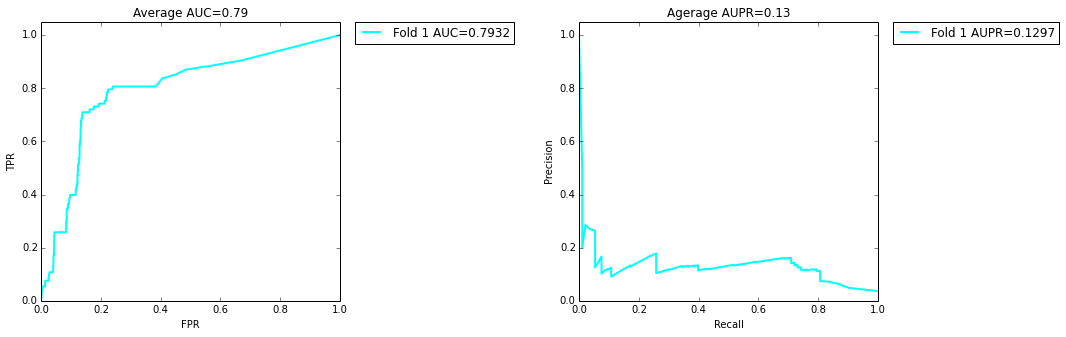

In [17]:
# 기존 dataset, independent, 2017.2.14. 작성 # 2017.2.24 수정.
print time.strftime('%a %H:%M:%S')
with open("/home/share/aschoi/nas/users/asolchoi/data/Drug_Repositioning/8_new_training/RF_original__indep_ver2.txt", 'w') as f :
    
    indep_fpr, indep_tpr, indep_thresholds = roc_curve(indep_y, indep_y_predicted_proba[:, 1], pos_label = 1)
    indep_auc = auc(indep_fpr, indep_tpr)
    indep_sn, indep_sp, _ = sensitivity_specificity_support(indep_y, indep_y_predicted_label)
    indep_precision, indep_recall, _, _ = precision_recall_fscore_support(indep_y, indep_y_predicted_label, average = 'binary')
    indep_aupr = average_precision_score(indep_y, indep_y_predicted_proba[:, 1])
    indep_confusion_matirx = confusion_matrix(indep_y, indep_y_predicted_label)
    indep_precision_vec, indep_recall_vec, _ = precision_recall_curve(indep_y, indep_y_predicted_proba[:, 1])
    
    f.write("Accuracy : {}\r\n".format(indep_accuracy))
    f.write("AUC : {}\r\n".format(indep_auc))
    f.write("  Sensitivity avg : {}\r\n".format(indep_sn))
    f.write("  Specificity avg : {}\r\n".format(indep_sp))
    f.write("AUPR : {}\r\n".format(indep_aupr))
    f.write("  Precision avg : {}\r\n".format(indep_precision))
    f.write("  Recall avg : {}\r\n".format(indep_recall))
    f.write("confusion amtrix : {}\r\n".format(indep_confusion_matirx))

    %matplotlib inline
    plt.clf()
    ff, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # setup plot details
    i=0
    lw = 2
    colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange', 'red', 'violet', 'fuchsia', 'sienna'])
    
    # plot AUC
    lab1 = 'Fold %d AUC=%.4f' % (i+1, indep_auc)
    axes[0].plot(indep_fpr, indep_tpr, lw=lw, color='cyan', label=lab1)
    
    
    # plot AUPR
    lab2 = 'Fold %d AUPR=%.4f' % (i+1, indep_aupr)
    axes[1].plot(indep_recall_vec, indep_precision_vec, lw=lw, color='cyan', label=lab2)
    
    
    axes[0].set_xlabel('FPR')
    axes[0].set_ylabel('TPR')
    axes[0].set_ylim([0.0, 1.05])
    axes[0].set_xlim([0.0, 1.0])
    axes[0].set_title('Average AUC={0:0.2f}'.format(indep_auc))
    axes[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
    axes[1].set_xlabel('Recall')
    axes[1].set_ylabel('Precision')
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_title('Agerage AUPR={0:0.2f}'.format(indep_aupr))
    axes[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
    ff.subplots_adjust(wspace=0.8)

print time.strftime('%a %H:%M:%S')

Fri 02:01:03
Fri 02:02:13


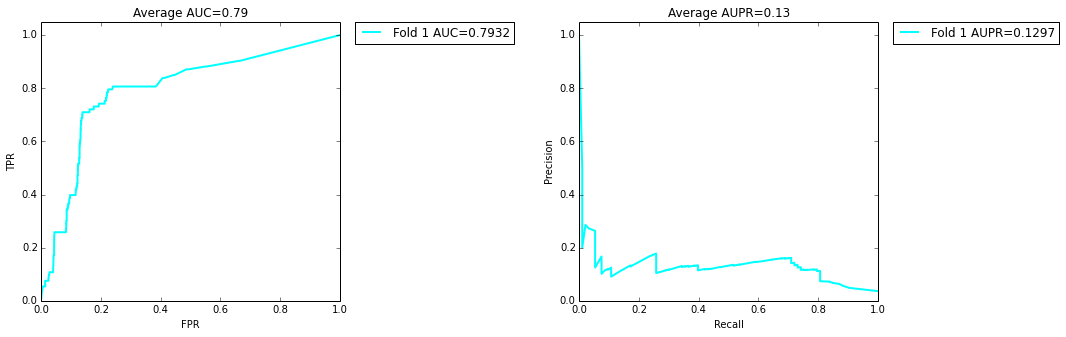

In [15]:
# 기존 dataset, independent, 2017.2.14. 작성 # 2017.2.24 수정.
print time.strftime('%a %H:%M:%S')
with open("/home/share/aschoi/nas/users/asolchoi/data/Drug_Repositioning/8_new_training/RF_0_1_ver2.txt", 'w') as f :
    user_estimators = 1200
    f.write("<independent>\r\n")
    
    classifier = RandomForestClassifier(n_estimators=user_estimators, n_jobs=-1, class_weight='balanced')
    classifier.fit(x_whole_data_0_1, y_whole_data_0_1)
    indep_y_predicted_proba = classifier.predict_proba(indep_x)
    indep_y_predicted_label = classifier.predict(indep_x)

    indep_accuracy = classifier.score(indep_x, indep_y)
    indep_fpr, indep_tpr, indep_thresholds = roc_curve(indep_y, indep_y_predicted_proba[:, 1], pos_label = 1)
    indep_auc = auc(indep_fpr, indep_tpr)
    indep_sn, indep_sp, _ = sensitivity_specificity_support(indep_y, indep_y_predicted_label)
    indep_precision, indep_recall, _, _ = precision_recall_fscore_support(indep_y, indep_y_predicted_label, average = 'binary')
    indep_aupr = average_precision_score(indep_y, indep_y_predicted_proba[:, 1])
    indep_confusion_matirx = confusion_matrix(indep_y, indep_y_predicted_label)
    indep_precision_vec, indep_recall_vec, _ = precision_recall_curve(indep_y, indep_y_predicted_proba[:, 1])
    
    f.write("Accuracy : {}\r\n".format(indep_accuracy))
    f.write("AUC : {}\r\n".format(indep_auc))
    f.write("  Sensitivity avg : {}\r\n".format(indep_sn))
    f.write("  Specificity avg : {}\r\n".format(indep_sp))
    f.write("AUPR : {}\r\n".format(indep_aupr))
    f.write("  Precision avg : {}\r\n".format(indep_precision))
    f.write("  Recall avg : {}\r\n".format(indep_recall))
    f.write("confusion amtrix : {}\r\n".format(indep_confusion_matirx))

    %matplotlib inline
    plt.clf()
    ff, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # setup plot details
    i=0
    lw = 2
    colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange', 'red', 'violet', 'fuchsia', 'sienna'])
    
    # plot AUC
    lab1 = 'Fold %d AUC=%.4f' % (i+1, indep_auc)
    axes[0].plot(indep_fpr, indep_tpr, lw=lw, color='cyan', label=lab1)
    
    
    # plot AUPR
    lab2 = 'Fold %d AUPR=%.4f' % (i+1, indep_aupr)
    axes[1].plot(indep_recall_vec, indep_precision_vec, lw=lw, color='cyan', label=lab2)
    
    
    axes[0].set_xlabel('FPR')
    axes[0].set_ylabel('TPR')
    axes[0].set_ylim([0.0, 1.05])
    axes[0].set_xlim([0.0, 1.0])
    axes[0].set_title('Average AUC={0:0.2f}'.format(indep_auc))
    axes[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
    axes[1].set_xlabel('Recall')
    axes[1].set_ylabel('Precision')
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_title('Average AUPR={0:0.2f}'.format(indep_aupr))
    axes[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
    ff.subplots_adjust(wspace=0.8)

print time.strftime('%a %H:%M:%S')

Thu 00:05:36


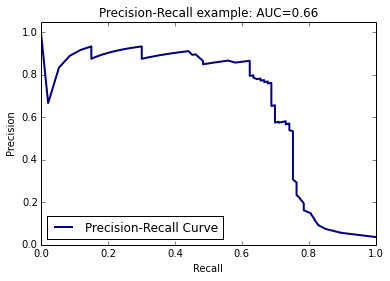

Original dataset shape Counter({0: 2462, 1: 93})

Resampled dataset shape Counter({0: 93, 1: 93})
Thu 00:15:17


In [87]:
# 기존 dataset, independent, 2017.2.14. 작성 # 2017.2.22. 수정.
print time.strftime('%a %H:%M:%S')
with open("/home/share/aschoi/nas/users/asolchoi/data/Drug_Repositioning/8_new_training/RF_original_label.txt", 'w') as f :
    user_estimators = 800
    f.write("<independent>\r\n")
    indep_results = Random_Forest_independent(x_whole_data, y_whole_data, indep_x, indep_y, user_estimators)
    write_output(f, indep_results)
    write_proba_output("RF_original_proba.txt", indep_results)
    draw_AUC_curve(indep_results[4])
    
    f.write("<independent 1:1>\r\n")
    indep_results_10 = Random_Forest_independent_10_fold(x_whole_data, y_whole_data, indep_x, indep_y, user_estimators, rus)
    write_output(f, indep_results_10)
    
print time.strftime('%a %H:%M:%S')

In [88]:
y_true = indep_results_10[4][0][0]
y_pre = indep_results_10[4][0][1]

In [89]:
print y_true.shape
print y_pre.shape

(186,)
(186, 2)


In [93]:
average_precision

0.91242513414827209

In [ ]:
aver

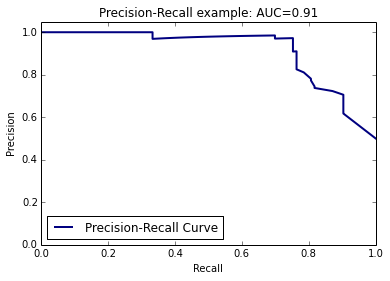

In [91]:
precision, recall, _ = precision_recall_curve(y_true, y_pre[:, 1])
average_precision = average_precision_score(y_true, y_pre[:, 1])

# setup plot details
%matplotlib inline

lw = 2
plt.clf()
plt.plot(recall, precision, lw=lw, color='navy', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall example: AUC={0:0.2f}'.format(average_precision))
plt.legend(loc="lower left")
plt.show()    

In [14]:
# undersampling dataset(1%), independent, 2017.2.14. 작성
print time.strftime('%a %H:%M:%S')
with open("/home/share/aschoi/nas/users/asolchoi/data/Drug_Repositioning/8_new_training/RF_2_2_feature_based(1%)_indep.txt", 'w') as f :
    user_estimators = 800
    f.write("<independent>\r\n")
    indep_results = Random_Forest_independent(x_whole_data_1, y_whole_data_1, indep_x, indep_y, user_estimators)
    write_output(f, indep_results)
    f.write("<independent 1:1>\r\n")
    indep_results_10 = Random_Forest_independent_10_fold(x_whole_data_1, y_whole_data_1, indep_x, indep_y, user_estimators, rus)
    write_output(f, indep_results_10)
print time.strftime('%a %H:%M:%S')

Wed 12:04:29
Wed 12:09:11


In [13]:
# undersampling dataset(0.5%), independent, 2017.2.14. 작성
print time.strftime('%a %H:%M:%S')
with open("/home/share/aschoi/nas/users/asolchoi/data/Drug_Repositioning/8_new_training/RF_2_3_feature_based(0.5%)_indep.txt", 'w') as f :
    user_estimators = 1200
    f.write("<independent>\r\n")
    indep_results = Random_Forest_independent(x_whole_data_0_5, y_whole_data_0_5, indep_x, indep_y, user_estimators)
    write_output(f, indep_results)
    f.write("<independent 1:1>\r\n")
    indep_results_10 = Random_Forest_independent_10_fold(x_whole_data_0_5, y_whole_data_0_5, indep_x, indep_y, user_estimators, rus)
    write_output(f, indep_results_10)
print time.strftime('%a %H:%M:%S')

Wed 11:56:36
Wed 12:04:29


In [12]:
# undersampling dataset(0.1%), independent, 2017.2.14. 작성
print time.strftime('%a %H:%M:%S')
with open("/home/share/aschoi/nas/users/asolchoi/data/Drug_Repositioning/8_new_training/RF_2_4_feature_based(0.1%)_indep.txt", 'w') as f :
    user_estimators = 1200
    f.write("<independent>\r\n")
    indep_results = Random_Forest_independent(x_whole_data_0_1, y_whole_data_0_1, indep_x, indep_y, user_estimators)
    write_output(f, indep_results)
    f.write("<independent 1:1>\r\n")
    indep_results_10 = Random_Forest_independent_10_fold(x_whole_data_0_1, y_whole_data_0_1, indep_x, indep_y, user_estimators, rus)
    write_output(f, indep_results_10)
print time.strftime('%a %H:%M:%S')

Wed 11:46:49
Wed 11:56:36


In [18]:
# 기존 dataset, Random undersampling, 2017.2.14. 작성
print time.strftime('%a %H:%M:%S')
with open("/home/share/aschoi/nas/users/asolchoi/data/Drug_Repositioning/8_new_training/RF_2_5_Random_undersampling.txt", 'w') as f :
    user_estimators = 1200
    print 'Random : ' + time.strftime('%a %H:%M:%S')
    f.write("<Random undersampling independent 1:1>\r\n")
    indep_results_10 = Random_Forest_independent_10_fold(x_whole_data, y_whole_data, indep_x, indep_y, user_estimators, rus)
    write_output(f, indep_results_10)
    
    print 'NearMiss : ' + time.strftime('%a %H:%M:%S')
    f.write("<NearMiss undersampling independent 1:1>\r\n")
    indep_results_10 = Random_Forest_independent_10_fold(x_whole_data, y_whole_data, indep_x, indep_y, user_estimators, nm)
    write_output(f, indep_results_10)
    
    print 'OneSidedSelection : ' + time.strftime('%a %H:%M:%S')
    f.write("<OneSidedSelection undersampling independent 1:1>\r\n")
    indep_results_10 = Random_Forest_independent_10_fold(x_whole_data, y_whole_data, indep_x, indep_y, user_estimators, oss)
    write_output(f, indep_results_10)
    
print time.strftime('%a %H:%M:%S')


Wed 15:25:33
Random : Wed 15:25:33
Original dataset shape Counter({0: 2462, 1: 93})

Resampled dataset shape Counter({0: 93, 1: 93})
NearMiss : Wed 15:37:22
Original dataset shape Counter({0: 2462, 1: 93})

Resampled dataset shape Counter({0: 93, 1: 93})
OneSidedSelection : Wed 15:49:35
Original dataset shape Counter({0: 2462, 1: 93})

Resampled dataset shape Counter({0: 2440, 1: 93})
Wed 16:06:33
